# Импортируем библиотеки 

In [1]:
import pandas as pd

from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, r2_score, mean_absolute_error, mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression   

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OneHotEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.feature_extraction.text import TfidfVectorizer



# Описание работы 

Наша задача состоит в работе с двумя датасетами, а именно классификация СМС(спам / не спам), а также предсказание рейтинга шоколада

Датасет для классификации содержит только текст из фичей, поэтому  последующую обработку мы будем проводить используя техники NLP, различные кодировщики,  а поверх просто накладывать ml модели.

Датасет для регрессии содержит классические фичи -> будем делать предобработку и EDA используя базу sklearn 

## KNN классификация 

Посмотрим на данные 

In [2]:
df = pd.read_csv("spam.csv", encoding="latin-1")


In [118]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [119]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [120]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

Кроме текста и таргета  нам ничего не нужно, уберем лишнее

In [3]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [4]:
df['label'] = df['v1'].map({'ham': 0, 'spam': 1})


In [123]:
df

,v1,v2,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1
5568,ham,Will Ì_ b going to esplanade fr home?,0
5569,ham,"Pity, * was in mood for that. So...any other s...",0
5570,ham,The guy did some bitching but I acted like i'd...,0


In [124]:
df['label'].value_counts()

label
0    4825
1     747
Name: count, dtype: int64

In [5]:
df = df.rename(columns={'v2': 'text'})

In [6]:
df = df.drop('v1', axis=1)

Итак все готово для построения baseline 

In [127]:
df

,text,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1
5568,Will Ì_ b going to esplanade fr home?,0
5569,"Pity, * was in mood for that. So...any other s...",0
5570,The guy did some bitching but I acted like i'd...,0


В качестве метрик будем использовать precision, recall и roc-auc

Precision чтобы понять долю реального спама среди всего, что модель пометила как спам.

Recall Доля найденного спама из всего реального спама.

ROC-AUC Насколько модель хорошо различает классы при разных порогах 

Наша главная цель как можно больше увеличить recall + roc-auc, при этом чтобы precision не сильно проседал 

### BASELINE 

В качестве бейслайна возьмем tfidf для векторизации текста со стоп словами из английского языка, приведем все к нижнему регистру, будем использовать униграммы и биграммы, игнорируем слова, встречающиеся в >5 доках 

+ поверх Logreg с параметрами по умолчанию 

In [7]:

X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']   
)


In [8]:

tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9
)


In [11]:

pipeline = Pipeline([
    ("tfidf", tfidf),
    ("clf", LogisticRegression())
])


In [12]:
pipeline.fit(X_train, y_train)


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [13]:

predict = pipeline.predict(X_test)
predict_proba = pipeline.predict_proba(X_test)[:, 1]


In [14]:
print(f"ROC-AUC: {roc_auc_score(y_test, predict_proba)}\nPRECISION: {precision_score(y_test, predict)}\nRECALL: {recall_score(y_test, predict)}")

ROC-AUC: 0.9849444884460933
PRECISION: 1.0
RECALL: 0.8322147651006712


Фиксируем стартовую точку

### Дальнейшие попытки улучшения 

Посмотрим детальнее на распределение таргета 

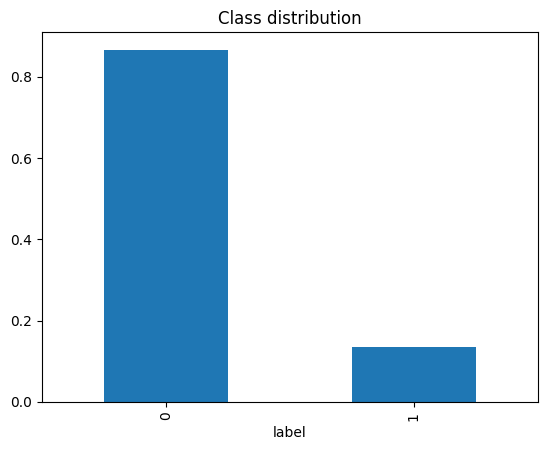

In [15]:
import matplotlib.pyplot as plt

df['label'].value_counts(normalize=True).plot(kind='bar')
plt.title("Class distribution")
plt.show()


Видим что около 85% на 15%, достаточно сильный дисбаланс 

Теперь первое что бросается в глаза, посмотрим на длину текста по классам 

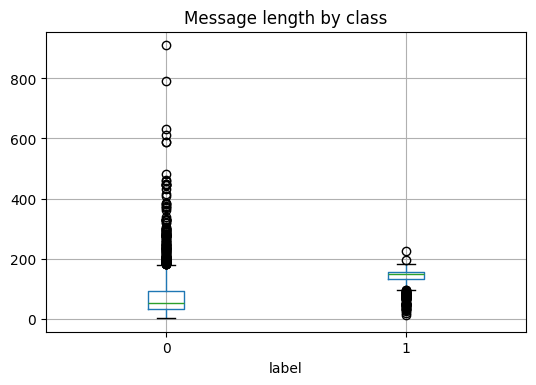

In [16]:
df['length'] = df['text'].str.len()

df.boxplot(column='length', by='label', figsize=(6,4))
plt.suptitle("")
plt.title("Message length by class")
plt.show()


Класс 0 
Медиана: короткие сообщения (~40–60 символов)

Большой разброс

Много длинных выбросов (до 900+ символов)

 Это нормально, например скорее всего личные переписки и тп


Класс 1 — spam

Медиана значительно выше (~130–150 символов)

Распределение более компактное

Меньше экстремально длинных сообщений

Это тоже ожидаемо тк скорее всего реклама, ссылки и тп 



Посмотрим на топ-слова спама 

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english', min_df=10)
X_counts = cv.fit_transform(df['text'])

word_freq = X_counts.toarray().sum(axis=0)
words = cv.get_feature_names_out()

freq_df = (
    pd.DataFrame({"word": words, "freq": word_freq})
      .sort_values("freq", ascending=False)
)

freq_df.head(20)


,word,freq
746,ur,385
370,just,371
304,gt,318
423,lt,316
506,ok,292
265,free,284
406,ll,269
376,know,261
400,like,245
297,good,245


Главный вывод - спам в среднем в 2–3 раза длиннее, добавим длину как фичу и будем использовать scaler для knn 

In [19]:
X = df[["text", "length"]]
y = df["label"]


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


И добавим также Normalizer 

Normalizer нормализует каждый объект целиком, устраняя влияние длины документа

In [21]:

preprocess = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.9), "text"),
        ("len", StandardScaler(), ["length"]),
    ]
)


In [45]:
pipeline = Pipeline([
    ("features", preprocess),
    ("norm", Normalizer()),          
    ("logreg", LogisticRegression())
])


In [46]:
pipeline.fit(X_train, y_train)

,steps,"[('features', ...), ('norm', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('text', ...), ('len', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [47]:

predict = pipeline.predict(X_test)
predict_proba = pipeline.predict_proba(X_test)[:, 1]


In [48]:
print(f"ROC-AUC: {roc_auc_score(y_test, predict_proba)}\nPRECISION: {precision_score(y_test, predict)}\nRECALL: {recall_score(y_test, predict)}")

ROC-AUC: 0.9824850278599914
PRECISION: 0.9848484848484849
RECALL: 0.87248322147651


Видим что recall еще немного подрос, теперь подберем гиперпараметры 

Теперь подберем гиперпараметры 

In [ ]:

pipeline = Pipeline([
    ("features", preprocess),
    ("norm", Normalizer()),
    ("clf", LogisticRegression(max_iter=3000, solver="saga"))
])

param_grid = {
    "clf__C": [0.001, 0.01, 0.1, 1, 3, 10, 30, 100],
    "clf__penalty": ["l1", "l2", "elasticnet"],
    "clf__l1_ratio": [0.0, 0.2, 0.5, 0.8, 1.0],
    "clf__class_weight": [None, "balanced"]
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1,
    refit=True
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_
best_params = grid.best_params_
y_pred = best_model.predict(X_test)


In [ ]:

y_pred = grid.predict(X_test)
predict_proba = grid.predict_proba(X_test)[:, 1]


In [ ]:
print(f"ROC-AUC: {roc_auc_score(y_test, predict_proba)}\nPRECISION: {precision_score(y_test, predict)}\nRECALL: {recall_score(y_test, predict)}")

ROC-AUC: 0.989925938277266
PRECISION: 1.0
RECALL: 0.8523489932885906


Итак подобранные гиперпараметры не помогли нам улучшить метрики 

На финальном этапе почистим текст, сделаем хорошую векторизацию + norm + scaler + logreg 

In [ ]:
import re

def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " URL ", s)
    s = re.sub(r"\d+", " NUMBER ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class TextCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = pd.Series(X.ravel())
        elif isinstance(X, pd.DataFrame):
            X = X.iloc[:, 0]
        return X.astype(str).apply(clean_text)

preprocess = ColumnTransformer(
    transformers=[
        ("text", Pipeline([
            ("clean", TextCleaner()),
            ("tfidf", TfidfVectorizer(
                analyzer="char",
                ngram_range=(3, 5),
                min_df=3,
                max_df=0.9,
                sublinear_tf=True
            ))
        ]), "text"),
        ("len", StandardScaler(), ["length"])
    ],
    remainder="drop"
)

pipeline = Pipeline([
    ("features", preprocess),
    ("norm", Normalizer(norm="l2")),
    ("logreg",  LogisticRegression())
])




In [ ]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

y_proba = pipeline.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PRECISION:", precision_score(y_test, y_pred))
print("RECALL:", recall_score(y_test, y_pred))


ROC-AUC: 0.9824850278599914
PRECISION: 0.9848484848484849
RECALL: 0.87248322147651


In [35]:
y_test.value_counts()

label
0    966
1    149
Name: count, dtype: int64

Отлично, после очистки метрики немного подросли, они существенно выросли по сравнению с knn 

### Собственная имплементация логистической регрессии

In [59]:
import numpy as np
from scipy import sparse
from sklearn.base import BaseEstimator, ClassifierMixin

class MyLogisticRegressionSK(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        C=1.0,
        penalty="l2",
        l1_ratio=0.0,
        class_weight=None,
        lr=0.1,
        n_iter=3000,
        tol=1e-7,
        fit_intercept=True,
        random_state=42
    ):
        self.C = C
        self.penalty = penalty
        self.l1_ratio = l1_ratio
        self.class_weight = class_weight
        self.lr = lr
        self.n_iter = n_iter
        self.tol = tol
        self.fit_intercept = fit_intercept
        self.random_state = random_state

    def _to_dense(self, X):
        return X.toarray() if sparse.issparse(X) else np.asarray(X, dtype=float)

    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    def _add_intercept(self, X):
        if not self.fit_intercept:
            return X
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def _compute_class_weights(self, y):
        if self.class_weight != "balanced":
            return np.ones_like(y, dtype=float)
        classes, counts = np.unique(y, return_counts=True)
        total = y.shape[0]
        weights = {
            cls: total / (len(classes) * cnt)
            for cls, cnt in zip(classes, counts)
        }
        return np.vectorize(weights.get)(y)

    def fit(self, X, y):
        X = self._to_dense(X)
        y = np.asarray(y, dtype=float).reshape(-1)
        X = self._add_intercept(X)

        n, d = X.shape
        w = np.zeros(d)
        reg = 1.0 / self.C
        sample_weight = self._compute_class_weights(y)
        eps = 1e-12

        last_loss = np.inf

        for _ in range(self.n_iter):
            z = X @ w
            p = self._sigmoid(z)

            grad = (X.T @ ((p - y) * sample_weight)) / n

            if self.penalty == "l2":
                grad[1:] += reg * w[1:]
            elif self.penalty == "elasticnet":
                grad[1:] += reg * (
                    self.l1_ratio * np.sign(w[1:]) +
                    (1 - self.l1_ratio) * w[1:]
                )

            w -= self.lr * grad

            loss = -np.mean(
                sample_weight * (
                    y * np.log(p + eps) +
                    (1 - y) * np.log(1 - p + eps)
                )
            )

            if self.penalty == "l2":
                loss += 0.5 * reg * np.sum(w[1:] ** 2)
            elif self.penalty == "elasticnet":
                loss += reg * (
                    self.l1_ratio * np.sum(np.abs(w[1:])) +
                    0.5 * (1 - self.l1_ratio) * np.sum(w[1:] ** 2)
                )

            if abs(last_loss - loss) < self.tol:
                break
            last_loss = loss

        self.coef_ = w[1:].reshape(1, -1)
        self.intercept_ = np.array([w[0]])
        self._w = w
        self.classes_ = np.array([0, 1])
        return self

    def predict_proba(self, X):
        X = self._to_dense(X)
        X = self._add_intercept(X)
        p1 = self._sigmoid(X @ self._w)
        return np.vstack([1 - p1, p1]).T

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)


In [44]:
grid.best_params_

{'clf__C': 30,
 'clf__class_weight': 'balanced',
 'clf__l1_ratio': 0.0,
 'clf__penalty': 'l2'}

In [60]:
pipeline = Pipeline([
    ("features", preprocess),
    ("norm", Normalizer()),
    ("clf", MyLogisticRegressionSK(
        C=30,
        penalty="l2",
        l1_ratio=0.0,
        class_weight="balanced",
        lr=0.05,
        n_iter=3000
    ))
])

pipeline.fit(X_train, y_train)



,steps,"[('features', ...), ('norm', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('text', ...), ('len', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [61]:

y_pred = pipeline.predict(X_test)

y_proba = pipeline.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PRECISION:", precision_score(y_test, y_pred))
print("RECALL:", recall_score(y_test, y_pred))


ROC-AUC: 0.9035182792113051
PRECISION: 0.37119113573407203
RECALL: 0.8993288590604027


Получили неплохие метрики для такой базовой реализации 

##  KNN(регрессия)

In [62]:
df = pd.read_csv('chocolate.csv')

In [ ]:
df

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating
0,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76%,"3- B,S,C","rich cocoa, fatty, bready",3.25
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76%,"3- B,S,C","cocoa, vegetal, savory",3.50
2,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76%,"3- B,S,C","cocoa, blackberry, full body",3.75
3,2542,5150,U.S.A.,2021,Fiji,"Matasawalevu, batch 1",68%,"3- B,S,C","chewy, off, rubbery",3.00
4,2546,5150,U.S.A.,2021,Venezuela,"Sur del Lago, batch 1",72%,"3- B,S,C","fatty, earthy, moss, nutty,chalky",3.00
...,...,...,...,...,...,...,...,...,...,...
2525,1205,Zotter,Austria,2014,Blend,Raw,80%,"4- B,S*,C,Sa","waxy, cloying, vegetal",2.75
2526,1996,Zotter,Austria,2017,Colombia,"APROCAFA, Acandi",75%,"3- B,S,C","strong nutty, marshmallow",3.75
2527,2036,Zotter,Austria,2018,Blend,"Dry Aged, 30 yr Anniversary bar",75%,"3- B,S,C","fatty, earthy, cocoa",3.00
2528,2170,Zotter,Austria,2018,Congo,Mountains of the Moon,70%,"3- B,S,C","fatty, mild nuts, mild fruit",3.25


In [ ]:
df.shape

(2530, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2530 entries, 0 to 2529
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ref                               2530 non-null   int64  
 1   company_manufacturer              2530 non-null   object 
 2   company_location                  2530 non-null   object 
 3   review_date                       2530 non-null   int64  
 4   country_of_bean_origin            2530 non-null   object 
 5   specific_bean_origin_or_bar_name  2530 non-null   object 
 6   cocoa_percent                     2530 non-null   object 
 7   ingredients                       2443 non-null   object 
 8   most_memorable_characteristics    2530 non-null   object 
 9   rating                            2530 non-null   float64
dtypes: float64(1), int64(2), object(7)
memory usage: 197.8+ KB


In [ ]:
df.describe()

,ref,review_date,rating
count,2530.000000,2530.000000,2530.000000
mean,1429.800791,2014.374308,3.196344
std,757.648556,3.968267,0.445321
min,5.000000,2006.000000,1.000000
25%,802.000000,2012.000000,3.000000
50%,1454.000000,2015.000000,3.250000
75%,2079.000000,2018.000000,3.500000
max,2712.000000,2021.000000,4.000000


Посмотрим на пропуски 

In [ ]:
df.isnull().sum()

ref                                  0
company_manufacturer                 0
company_location                     0
review_date                          0
country_of_bean_origin               0
specific_bean_origin_or_bar_name     0
cocoa_percent                        0
ingredients                         87
most_memorable_characteristics       0
rating                               0
dtype: int64

Они всего в одной колонке, заполним их случайной категорией

In [63]:
df["ingredients"] = df["ingredients"].fillna("Unknown")


In [147]:
df['cocoa_percent']

0       76%
1       76%
2       76%
3       68%
4       72%
       ... 
2525    80%
2526    75%
2527    75%
2528    70%
2529    72%
Name: cocoa_percent, Length: 2530, dtype: object

уберем проценты из этой колонки и переведем ее в число 

In [64]:
df["cocoa_percent"] = (
    df["cocoa_percent"]
    .astype(str)
    .str.replace("%", "", regex=False)
    .astype(float)
)


Теперь посмотрим на распределение целевой переменной

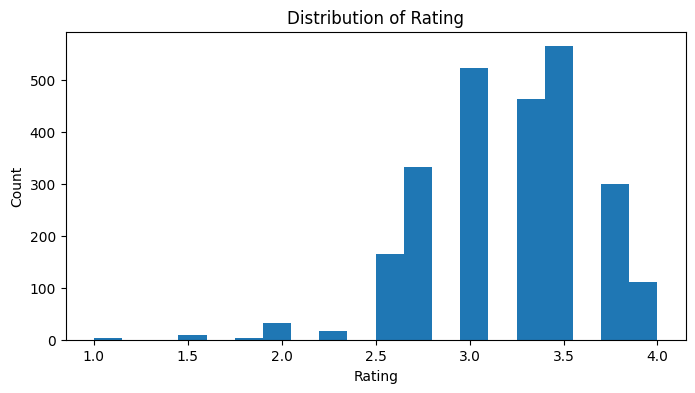

In [65]:
plt.figure(figsize=(8, 4))
plt.hist(df["rating"], bins=20)
plt.title("Distribution of Rating")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


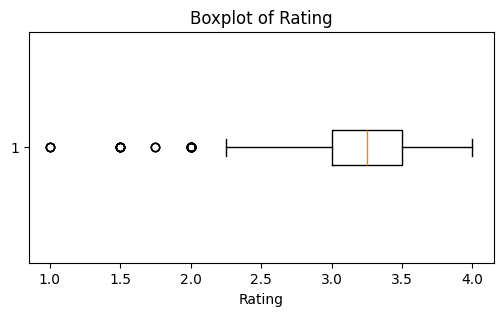

In [66]:
plt.figure(figsize=(6, 3))
plt.boxplot(df["rating"], vert=False)
plt.title("Boxplot of Rating")
plt.xlabel("Rating")
plt.show()


Посмотрим рейтинг по годам

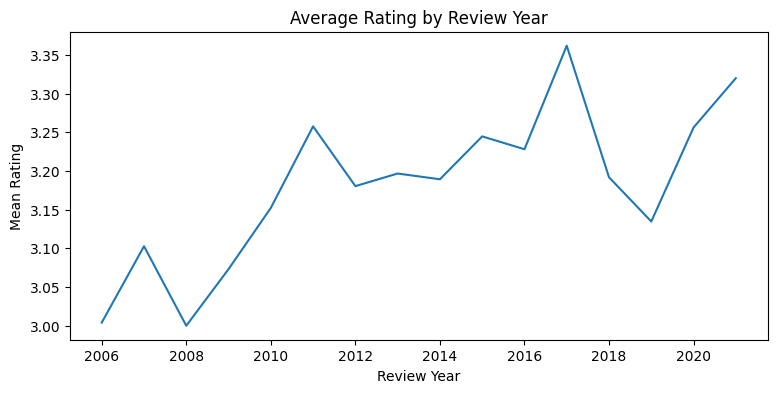

In [67]:
rating_by_year = df.groupby("review_date")["rating"].mean()

plt.figure(figsize=(9, 4))
plt.plot(rating_by_year.index, rating_by_year.values)
plt.title("Average Rating by Review Year")
plt.xlabel("Review Year")
plt.ylabel("Mean Rating")
plt.show()


Видим что средний рейтинг с каждым годом увеличивался, значит удалять дату нельзя

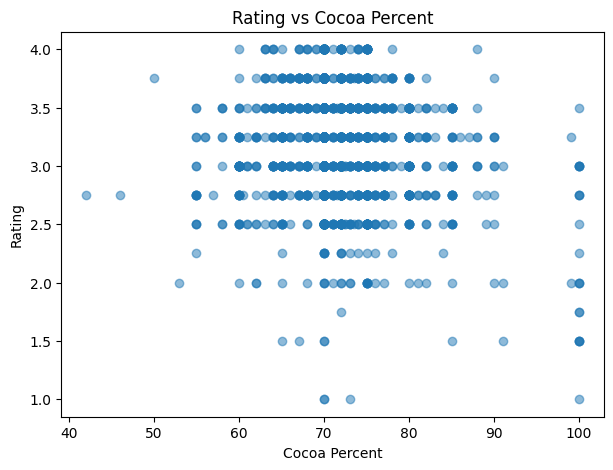

In [68]:
plt.figure(figsize=(7, 5))
plt.scatter(df["cocoa_percent"], df["rating"], alpha=0.5)
plt.title("Rating vs Cocoa Percent")
plt.xlabel("Cocoa Percent")
plt.ylabel("Rating")
plt.show()


Чёткой линейной зависимости нет.

Основная масса точек:

cocoa_percent в диапазоне 60–80%

rating в диапазоне 2.75–3.75

Для очень высокого какао (90–100%):

больше низких рейтингов,

высокая дисперсия.



Теперь посмотрим на корреляцию для числовых и категориальных 

In [69]:


num_cols = [
    "rating",
    "cocoa_percent",
    "review_date"
]

corr_num = df[num_cols].corr()


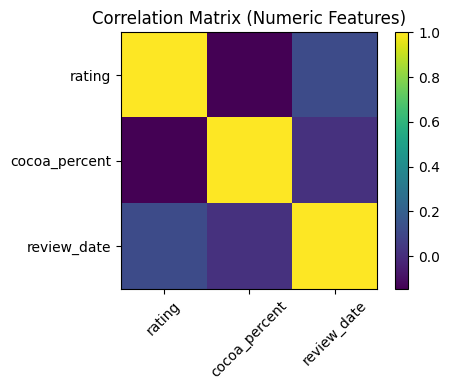

In [70]:
plt.figure(figsize=(5, 4))
plt.imshow(corr_num)
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=45)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation Matrix (Numeric Features)")
plt.tight_layout()
plt.show()


In [71]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))
    rcorr = r - ((r - 1)**2)/(n - 1)
    kcorr = k - ((k - 1)**2)/(n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


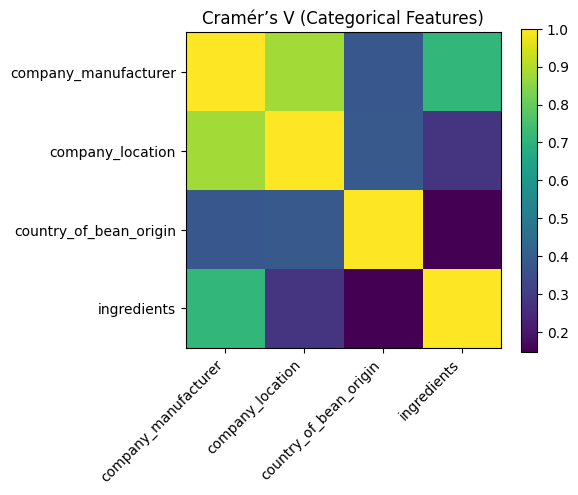

In [72]:
cat_cols = [
    "company_manufacturer",
    "company_location",
    "country_of_bean_origin",
    "ingredients"
]


cramers_matrix = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))),
    index=cat_cols,
    columns=cat_cols
)

for col1 in cat_cols:
    for col2 in cat_cols:
        cramers_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

plt.figure(figsize=(6, 5))
plt.imshow(cramers_matrix)
plt.colorbar()
plt.xticks(range(len(cat_cols)), cat_cols, rotation=45, ha="right")
plt.yticks(range(len(cat_cols)), cat_cols)
plt.title("Cramér’s V (Categorical Features)")
plt.tight_layout()
plt.show()


Топ страны vs средний рейтинг 

In [73]:
TOP_N = 15

top_countries = df["company_location"].value_counts().head(TOP_N).index

country_stats = (
    df[df["company_location"].isin(top_countries)]
    .groupby("company_location")["rating"]
    .agg(["mean", "count"])
    .sort_values("count", ascending=False)
)


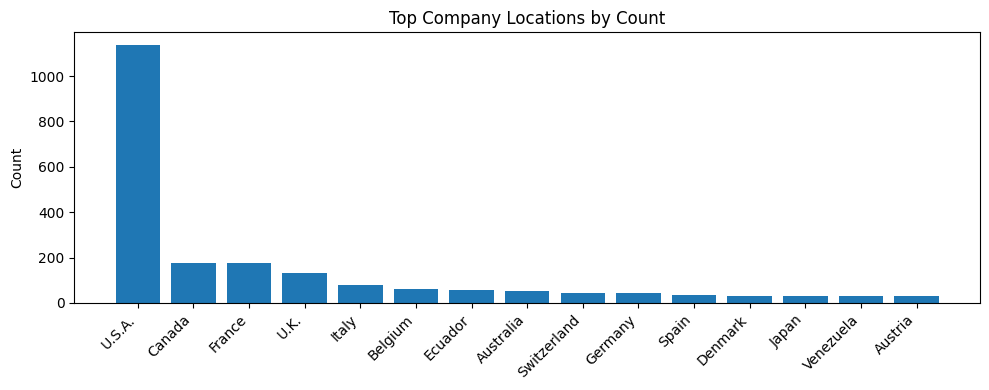

In [74]:
plt.figure(figsize=(10, 4))
plt.bar(country_stats.index, country_stats["count"])
plt.title("Top Company Locations by Count")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Большинство компаний в США

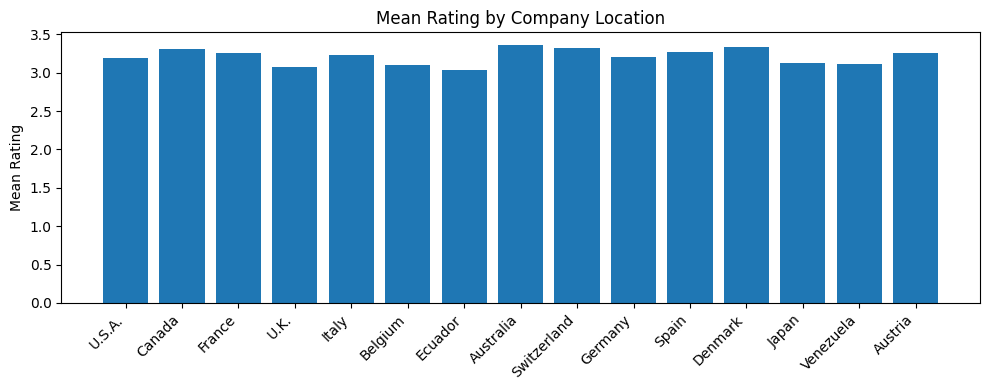

In [75]:
plt.figure(figsize=(10, 4))
plt.bar(country_stats.index, country_stats["mean"])
plt.title("Mean Rating by Company Location")
plt.ylabel("Mean Rating")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [76]:
top_companies = df["company_manufacturer"].value_counts().head(TOP_N).index

company_stats = (
    df[df["company_manufacturer"].isin(top_companies)]
    .groupby("company_manufacturer")["rating"]
    .agg(["mean", "count"])
    .sort_values("count", ascending=False)
)


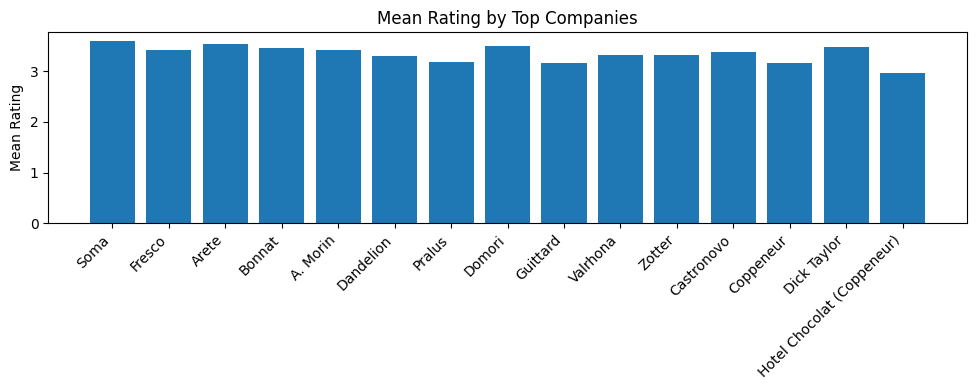

In [77]:
plt.figure(figsize=(10, 4))
plt.bar(company_stats.index, company_stats["mean"])
plt.title("Mean Rating by Top Companies")
plt.ylabel("Mean Rating")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


В остальном картина примерно одиннакова для производетелей и стран 

Теперь закодируем признаки и проведем feature engineering

Число ингридиентов

In [78]:
def parse_n_ingredients(x):
    try:
        return int(x.split("-")[0])
    except:
        return np.nan

df["n_ingredients"] = df["ingredients"].apply(parse_n_ingredients)


Длина текстового описания 

In [79]:
df["mmc_len"] = (
    df["most_memorable_characteristics"]
    .astype(str)
    .str.split()
    .str.len()
)


Время ревью 

In [80]:
df["review_age"] = df["review_date"].max() - df["review_date"]


In [81]:
num_features = [
    "cocoa_percent",
    "review_date",
    "review_age",
    "n_ingredients",
    "mmc_len"
]

cat_features = [
    "company_manufacturer",
    "company_location",
    "country_of_bean_origin",
    "ingredients"
]

drop_cols = [
    "ref",
    "specific_bean_origin_or_bar_name"
]



Заполним пропуски у количества ингридиентов в случае инцидента

In [82]:
df["n_ingredients"] = df["n_ingredients"].fillna(
    df["n_ingredients"].median()
)


In [83]:
X = df.drop('rating', axis=1)
y = df['rating']

In [84]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


#### BASELINE

В качестве baseline будем использовать линейную регрессию и также возьмем скейлер, поскольку имеем дело с линейной моделью 

В качестве кодировщика возьмем базовый one-hot

In [86]:

numeric_pipe = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_features),
        ("cat", categorical_pipe, cat_features),
    ],
    remainder="drop"
)


model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("linreg", LinearRegression())
])

model.fit(X_train, y_train)



,steps,"[('preprocess', ...), ('linreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Напишем функцию для удобного расчета метрик 

MAE (Mean Absolute Error)

Показывает среднюю ошибку в тех же единицах, что и рейтинг.

Бизнесу легко интерпретировать:

«в среднем мы ошибаемся на ±0.2 балла рейтинга».

Устойчив к выбросам → хорошо отражает типичную ошибку для большинства продуктов.

RMSE (Root Mean Squared Error)

Сильнее штрафует большие ошибки.

Важно для бизнеса, потому что:
сильные промахи (предсказали 4.0, а реально 2.5) критичнее,
помогает контролировать риск плохих рекомендаций или неверных решений по продукту.

R² (коэффициент детерминации)

Показывает, какую долю вариации рейтинга объясняет модель.
Удобен для сравнения моделей и коммуникации со стейкхолдерами:
«модель объясняет 60% различий в оценках шоколада».

In [87]:

def print_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f" MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2:   {r2:.4f}")



In [88]:
y_pred = model.predict(X_test)

print_metrics(y_test, y_pred)

 MAE:  0.3512
RMSE: 0.4508
R2:   0.0211


Теперь подберем гиперпараметры, использовать будем elasticnet чтобы соблюдать баланс между l1 и l2

In [ ]:
from sklearn.linear_model import ElasticNet

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("enet", ElasticNet(max_iter=20000, random_state=42))
])

param_grid = {
    "enet__alpha": [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1.0, 3.0, 10.0],
    "enet__l1_ratio": [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    "enet__fit_intercept": [True, False]
}

gs = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=1,
    refit=True
)

gs.fit(X_train, y_train)

best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)


In [90]:
print_metrics(y_test, y_pred)

 MAE:  0.3296
RMSE: 0.4161
R2:   0.1661


Удалось слегка повысить r2, для таких непростых данных это хорошо, но чтобы повысить их до приемлемого уровня явно нужны модели посильнее

#### Имплементация линейной регрессии 

Попытаемся приблизиться к elasticnet

In [94]:
import numpy as np
from scipy import sparse
from sklearn.base import BaseEstimator, RegressorMixin

class MyElasticNet(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        alpha=1.0,
        l1_ratio=0.5,
        lr=0.01,
        n_iter=5000,
        tol=1e-6,
        fit_intercept=True
    ):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.lr = lr
        self.n_iter = n_iter
        self.tol = tol
        self.fit_intercept = fit_intercept

    def _to_dense(self, X):
        return X.toarray() if sparse.issparse(X) else np.asarray(X, dtype=float)

    def _add_intercept(self, X):
        if not self.fit_intercept:
            return X
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def fit(self, X, y):
        X = self._to_dense(X)
        y = np.asarray(y, dtype=float).reshape(-1)
        X = self._add_intercept(X)

        n, d = X.shape
        w = np.zeros(d)
        last_loss = np.inf

        for _ in range(self.n_iter):
            y_pred = X @ w
            error = y_pred - y

            grad = (X.T @ error) / n

            if self.fit_intercept:
                reg_w = w[1:]
            else:
                reg_w = w

            grad_l2 = self.alpha * (1 - self.l1_ratio) * reg_w
            grad_l1 = self.alpha * self.l1_ratio * np.sign(reg_w)

            if self.fit_intercept:
                grad[1:] += grad_l2 + grad_l1
            else:
                grad += grad_l2 + grad_l1

            w -= self.lr * grad

            loss = (
                np.mean(error ** 2)
                + self.alpha * (
                    self.l1_ratio * np.sum(np.abs(reg_w))
                    + (1 - self.l1_ratio) * np.sum(reg_w ** 2)
                )
            )

            if abs(last_loss - loss) < self.tol:
                break
            last_loss = loss

        self._w = w
        if self.fit_intercept:
            self.intercept_ = w[0]
            self.coef_ = w[1:]
        else:
            self.intercept_ = 0.0
            self.coef_ = w

        return self

    def predict(self, X):
        X = self._to_dense(X)
        X = self._add_intercept(X)
        return X @ self._w


Обучим с лучшими гиперпараметрами 

In [100]:
from sklearn.pipeline import Pipeline

enet_custom = MyElasticNet(
    alpha=0.003,
    l1_ratio=0.0,
    fit_intercept=True,
    n_iter=20000,
    tol=1e-4
)

pipeline = Pipeline([
    ("preprocess", preprocess),
    ("enet", enet_custom)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


In [101]:
print_metrics(y_test, y_pred)

 MAE:  0.3743
RMSE: 0.4659
R2:   -0.0454


По mae и rmse приблизились к реализации из sklearn, а вот r2 конечно оставляет желать лучшего 